#**Imports**

In [6]:
!pip install gym[box2d]

zsh:1: no matches found: gym[box2d]


In [7]:
from io import IncrementalNewlineDecoder
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
# # save a copy of the project in your drive and then this should work for all those who use it.
# %cd /content/drive/MyDrive/Modularized\ Copy\ of\ Project 
# # %cd /content/drive/MyDrive/CompSci\ 691NR/Modularized\ Copy\ of\ Project
# !ls
import config
from Replay import ReplayBuffer, ExpertReplayBuffer
from Network import SoftQNetwork, SoftDQNAgent, QNetwork
from Agent import DQNAgent

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#**Gym Environment**

In [10]:
env = gym.make('LunarLander-v2')
env.reset(seed=0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
!ls

Agent.py			 OurAlgCallEpisodes.txt
baseline_2.zip			 OurAlgNoExpPriorScores.txt
baseline_Max.zip		 OurAlgNoExpPriorStd.txt
BenchmarkLunarLander.ipynb	 OurAlgNoExpScores.txt
BenchmarkScores.txt		 OurAlgNoExpStd.txt
BenchmarkStd.txt		 OurAlgScores.txt
config.py			 OurAlgStd.txt
environments.yaml		 ourAlg.zip
ExpertLunarLander.ipynb		 OurLunarLander.ipynb
expertScores.txt		 __pycache__
expert.zip			 Replay.py
FinalPPTShrayaniYugantar.pptx	 solved_200.pth
FromScratchOurLunarLander.ipynb  solved_baseline.pth
Network.py			 solved_Benchmark_Max.pth
ogDQNScores.txt			 solved_Benchmark.pth
ogDQNStd.txt			 solved_OG.pth
ogDQN.txt			 solved_OurAlg.pth
OgLunarLanderDQN.ipynb		 utils.py


#**Train**

In [28]:
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
expertAgent = SoftDQNAgent(state_size, action_size, seed=0, algo = "benchmark")
expertAgent.q_network.load_state_dict(torch.load('expert.zip'))
expertAgent.q_network.eval()


SoftQNetwork(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

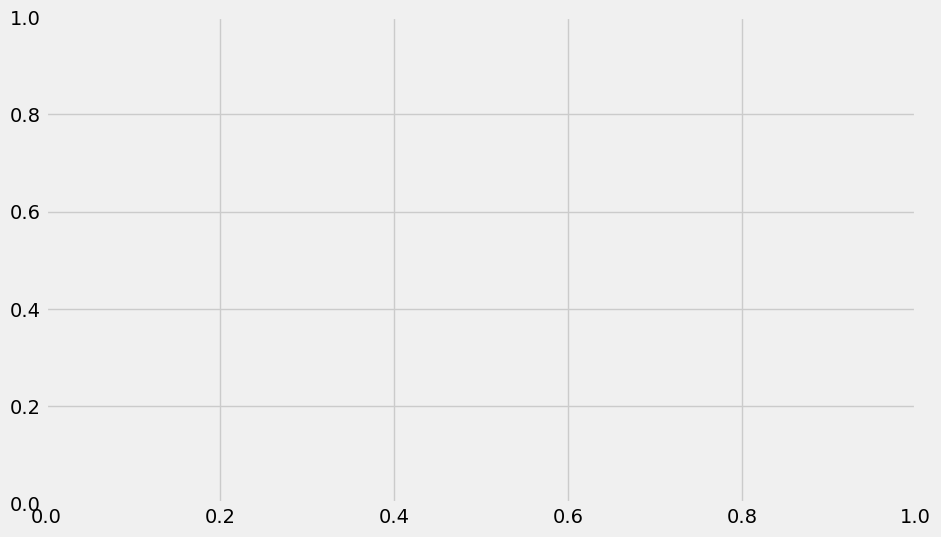

In [29]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)

In [38]:
%reload_ext autoreload
dqn_agent = DQNAgent(state_size, action_size, seed=0)
dqn_agent.expertStoreKL(expertAgent, env)

In [37]:
%reload_ext autoreload
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = config.EPS_START

for episode in range(1, config.MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(config.MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, truncated, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * config.EPS_DECAY, config.EPS_MIN)
        if episode % config.PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, config.MAX_EPISODES, mean_score), end="")
        if score >= config.ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_Benchmark_Max.pth')
            break
            
    scores_window.append(score)
    scores.append(score)
    ax.set_xlim(0,episode)
    ax.cla()
    ax.plot(scores)
    ax.plot(pd.Series(scores).rolling(100).mean())
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)
    
end = time()    
print('Took {} seconds'.format(end - start))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/chaoticmonkey/anaconda3/envs/DQfLD/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_18287/3750450885.py", line 14, in <module>
    dqn_agent.step(state, action, reward, next_state, done)
  File "/home/chaoticmonkey/Desktop/Spring22/DeepQLearning_with_LimDemonstrations/Agent.py", line 70, in step
    sampled_experiences = self.memory.sample()
  File "/home/chaoticmonkey/Desktop/Spring22/DeepQLearning_with_LimDemonstrations/Replay.py", line 42, in sample
    print('replay buffer shapes:',[experience.state.shape for experience in experiences if experience is not None])
  File "/home/chaoticmonkey/Desktop/Spring22/DeepQLearning_with_LimDemonstrations/Replay.py", line 42, in <listcomp>
    print('replay buffer shapes:',[experience.state.shape for experience in experiences if experience is not None])
AttributeError: 'tuple' object

In [ ]:
dqn_agent.checkpoint('solved_Benchmark_Max.pth')
torch.save(dqn_agent.q_network.state_dict(),'./baseline_Max')

[autoreload of Agent failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/drive/.shortcut-targets-by-id/1LAVFkxWwrAbAFud77JlToDV-DpKKp58x/Modularized Copy of Project/Agent.py", line 454
    """ TEMP
           ^
TabError: inconsistent use of tabs and spaces in indentation
]


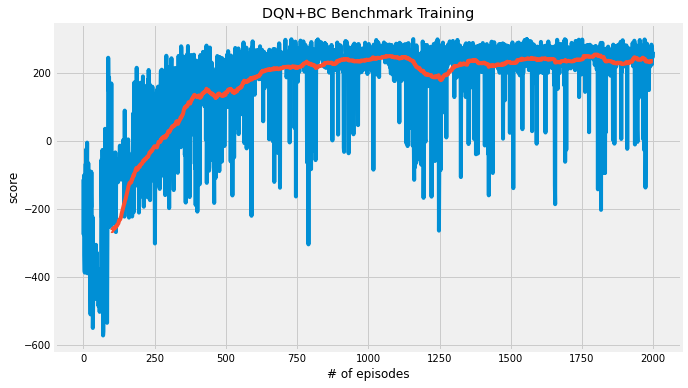

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN+BC Benchmark Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [ ]:
%reload_ext autoreload
avg_scores = [] #stores the scores over all experiments
avg_std_window = [] #stores the standard deviations of the rolling window over all experiments
start = time()
for exp in range(5):
    dqn_agent = DQNAgent(state_size, action_size, seed=0)
    dqn_agent.expertStoreKL(expertAgent, env) 
    scores = []
    std_array = []

    # Maintain a list of last 100 scores
    scores_window = deque(maxlen=100)
    scores_window_std = deque(maxlen=50)
    eps = config.EPS_START
    for episode in range(1, config.MAX_EPISODES + 1):
        state = env.reset()
        score = 0
        for t in range(config.MAX_STEPS):
            action = dqn_agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            dqn_agent.step(state, action, reward, next_state, done)
            state = next_state        
            score += reward
            if done:
                break
                
            eps = max(eps* config.EPS_DECAY, config.EPS_MIN)
            if episode % config.PRINT_EVERY == 0:
                mean_score = np.mean(scores_window)
                print('\r Progress {}/{}, average score:{:.2f}'.format(episode, config.MAX_EPISODES, mean_score), end="")
            if score >= config.ENV_SOLVED:
                mean_score = np.mean(scores_window)
                print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
                sys.stdout.flush()
                dqn_agent.checkpoint('solved_Benchmark.pth')
                break
                
        #storing scores for plotting later
        scores_window.append(score) 
        scores.append(score)
        #storing std array for kids
        scores_window_std.append(np.mean(scores_window))
        std_array.append(np.std(scores_window_std , dtype=np.float32))
        
        #plotting real time graph
        ax.set_xlim(0,episode)
        ax.cla()
        ax.plot(scores)
        ax.plot(pd.Series(scores).rolling(100).mean())
        ax.set_title('Experiment number ' + str(exp+1)+ ' for Benchmark DQN + LfD')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)
  
    avg_std_window.append(std_array)
    avg_scores.append(scores)
    del dqn_agent
    
end = time()    
print('Took {} seconds'.format(end - start))

Took 9916.042229890823 seconds


In [ ]:
textfile = open("BenchmarkScores.txt", "w")
textfile.write(str(avg_scores))
textfile.close()

textfile = open("BenchmarkStd.txt", "w")
textfile.write(str(avg_std_window))
textfile.close()

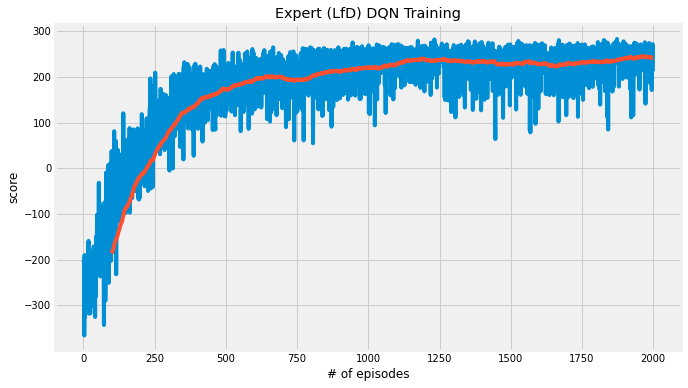

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(avg_scores, axis=0))
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean())
plt.title('Expert (LfD) DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [ ]:
with open("BenchmarkScores.txt", "r") as f:
    bobs = []

    for lines in f:
        lines = lines[1:-1].split("[")

        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs.append(arr)

with open("ogDQNScores.txt", "r") as f:
    bobs2 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs2.append(arr)

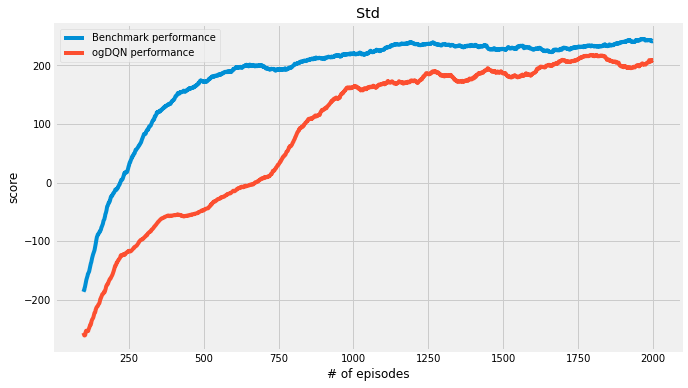

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0)).rolling(100).mean(), label='Benchmark performance')
plt.plot(pd.Series(np.mean(bobs2, axis=0)).rolling(100).mean(), label='ogDQN performance')
# plt.plot(bobs3[:1000], label='decay Std')
# A bit hard to see the above plot, so lets smooth it (red)
# plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean())
plt.title('Std')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.legend()
plt.show()

In [2]:
with open("BenchmarkScores.txt", "r") as f:
    bobs = []

    for lines in f:
        lines = lines[1:-1].split("[")

        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs.append(arr)

with open("ogDQNScores.txt", "r") as f:
    bobs2 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs2.append(arr)

with open("OurAlgScores.txt", "r") as f:
    bobs3 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs3.append(arr)

with open("OurAlgNoExpScores.txt", "r") as f:
    bobs4 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]
                            bobs4.append(arr)

In [3]:
alpha=0.2

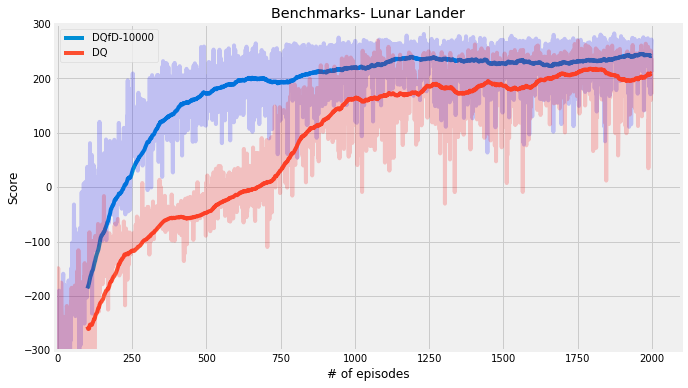

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0)).rolling(100).mean(), label='DQfD-10000')
plt.plot(pd.Series(np.mean(bobs, axis=0)), color='blue', alpha=alpha)
plt.plot(pd.Series(np.mean(bobs2, axis=0)).rolling(100).mean(), label='DQ')
plt.plot(pd.Series(np.mean(bobs2, axis=0)), color='red', alpha=alpha)
# plt.plot(pd.Series(np.mean(bobs3, axis=0)).rolling(100).mean(), label='ourAlg')
# plt.plot(pd.Series(np.mean(bobs4, axis=0)).rolling(100).mean(), label ='our Alg no expert')
# plt.plot(bobs3[:1000], label='decay Std')
# A bit hard to see the above plot, so lets smooth it (red)
# plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean(), label='Priortized Replay')
plt.title('Benchmarks- Lunar Lander')
plt.ylim(-300, 300)
plt.xlim(-10)
plt.xlabel('# of episodes')
plt.ylabel('Score')
plt.legend()
plt.show()

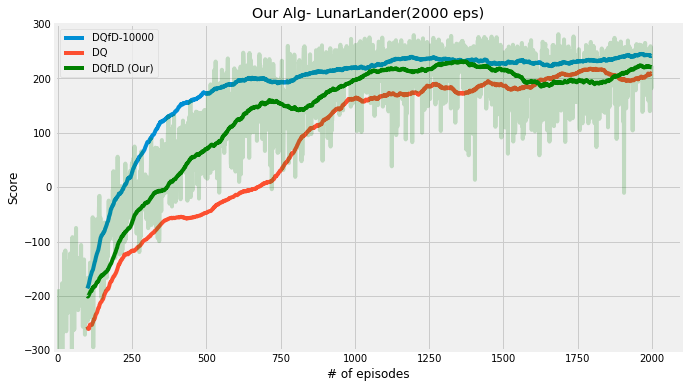

In [4]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0)).rolling(100).mean(), label='DQfD-10000')
# plt.plot(pd.Series(np.mean(bobs, axis=0)), color='blue', alpha=alpha)
plt.plot(pd.Series(np.mean(bobs2, axis=0)).rolling(100).mean(), label='DQ')
# plt.plot(pd.Series(np.mean(bobs2, axis=0)), color='red', alpha=alpha)
plt.plot(pd.Series(np.mean(bobs3, axis=0)).rolling(100).mean(), color='green', label='DQfLD (Our)')
plt.plot(pd.Series(np.mean(bobs3, axis=0)), color='green', alpha=alpha)
# plt.plot(pd.Series(np.mean(bobs4, axis=0)).rolling(100).mean(), label ='our Alg no expert')
# plt.plot(bobs3[:1000], label='decay Std')
# A bit hard to see the above plot, so lets smooth it (red)
# plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean(), label='Priortized Replay')

plt.title('Our Alg- LunarLander(2000 eps)')
plt.ylim(-300, 300)
plt.xlim(-10)
plt.xlabel('# of episodes')
plt.ylabel('Score')
plt.legend()
plt.show()

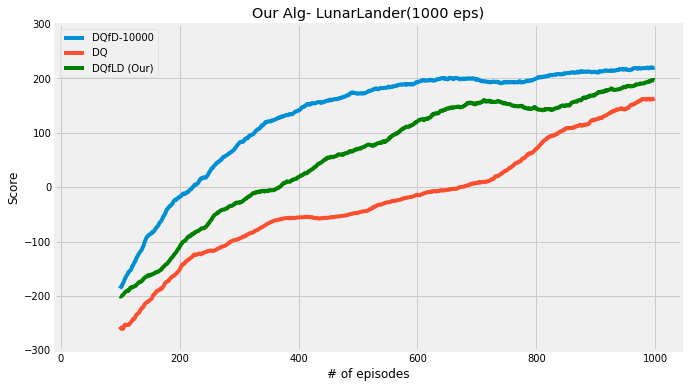

In [5]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0))[:1000].rolling(100).mean(), label='DQfD-10000')
# plt.plot(pd.Series(np.mean(bobs, axis=0))[:1000], color='blue', alpha=alpha)
plt.plot(pd.Series(np.mean(bobs2, axis=0))[:1000].rolling(100).mean(), label='DQ')
# plt.plot(pd.Series(np.mean(bobs2, axis=0))[:1000], color='red', alpha=alpha)
plt.plot(pd.Series(np.mean(bobs3, axis=0))[:1000].rolling(100).mean(), color='green', label='DQfLD (Our)')
# plt.plot(pd.Series(np.mean(bobs4, axis=0)).rolling(100).mean(), label ='our Alg no expert')
# plt.plot(bobs3[:1000], label='decay Std')
# A bit hard to see the above plot, so lets smooth it (red)
# plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean(), label='Priortized Replay')
plt.title('Our Alg- LunarLander(1000 eps)')
plt.ylim(-300, 300)
plt.xlim(-10)
plt.xlabel('# of episodes')
plt.ylabel('Score')
plt.legend()

# xcoords = bobs5[2]
# for xc in xcoords:
#     plt.axvline(x=xc)


plt.show()

In [6]:
with open("OurAlgCallEpisodes.txt", "r") as f:
    bobs5 = []

    for lines in f:
        lines = lines[1:-1].split("[")
        for line in lines:
            bobs_exp = []
            if line:
                line = line.split("]")
                for l in line:
                    l = l.split(", ")
                    if l:
                        if l[0]:
                            arr = [float(i) for i in l]

                            bobs5.append(arr)

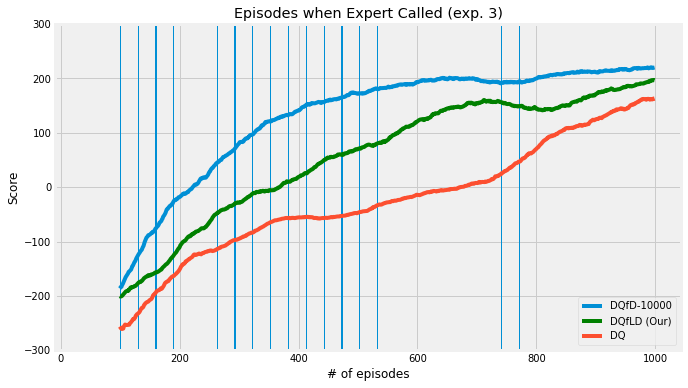

In [7]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0))[:1000].rolling(100).mean(), label='DQfD-10000')
plt.plot(pd.Series(np.mean(bobs3, axis=0))[:1000].rolling(100).mean(), color='green', label='DQfLD (Our)')
plt.plot(pd.Series(np.mean(bobs2, axis=0))[:1000].rolling(100).mean(), label='DQ')
xcoords = bobs5[2][:-1]
for xc in xcoords:
    # plt.axvline(x=xc)
    plt.axvspan(xc-1, xc+1)
# plt.axvspan(60-40/2,60+40/2, alpha=0.5)
plt.title('Episodes when Expert Called (exp. 3)')
plt.ylim(-300, 300)
plt.xlim(-10)
plt.xlabel('# of episodes')
plt.ylabel('Score')
plt.legend()
plt.show()

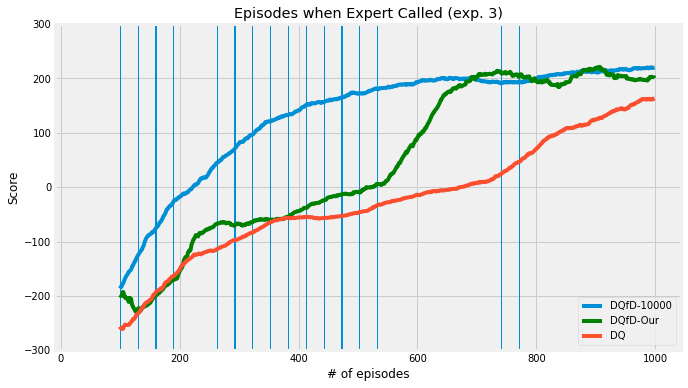

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pd.Series(np.mean(bobs, axis=0))[:1000].rolling(100).mean(), label='DQfD-10000')
plt.plot(pd.Series(bobs3[2])[:1000].rolling(100).mean(), color='green', label='DQfD-Our')
plt.plot(pd.Series(np.mean(bobs2, axis=0))[:1000].rolling(100).mean(), label='DQ')
xcoords = bobs5[2][:-1]
for xc in xcoords:
    # plt.axvline(x=xc)
    plt.axvspan(xc-1, xc+1)
# plt.axvspan(60-40/2,60+40/2, alpha=0.5)
plt.title('Episodes when Expert Called (exp. 3)')
plt.ylim(-300, 300)
plt.xlim(-10)
plt.xlabel('# of episodes')
plt.ylabel('Score')
plt.legend()
plt.show()